# California Property Prediction Exercise

### Load Packages

In [1]:

import sys
assert sys.version_info >= (3, 5)
import pandas as pd

import sklearn

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
# Where to save the figures
PROJECT_ROOT_DIR = r"C:\Users\johnl\Documents\California Housing"
os.makedirs(PROJECT_ROOT_DIR, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
housing = pd.read_csv(r"C:\Users\johnl\Documents\California Housing\housing.csv")

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns
missing_values_table(housing)

Your selected dataframe has 10 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
total_bedrooms,207,1.0


Only one column with missing values with a relatively low amount of missing values

In [6]:
def cat_column_counts(df):
    cat_cols = df.select_dtypes(include=object).columns.tolist()
    return (pd.DataFrame(
        housing[cat_cols]
        .melt(var_name='column', value_name='value')
        .value_counts())
    .rename(columns={0: 'counts'})
    .sort_values(by=['column', 'counts']))
cat_column_counts(housing)

counts
column          value             
ocean_proximity ISLAND           5
                NEAR BAY      2290
                NEAR OCEAN    2658
                INLAND        6551
                <1H OCEAN     9136

we have one object feature **ocean_proximity** which is a catgorical feature with 5 catogories

In [7]:
def describe_advanced(df):
    stats = df.describe()
    stats.loc['var'] = df.var().tolist()
    stats.loc['skew'] = df.skew().tolist()
    stats.loc['kurt'] = df.kurtosis().tolist()
    return stats
describe_advanced(housing)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,2.064000e+04,20433.000000,2.064000e+04,20640.000000,20640.000000,2.064000e+04
mean,-119.569704,35.631861,28.639486,2.635763e+03,537.870553,1.425477e+03,499.539680,3.870671,2.068558e+05
std,2.003532,2.135952,12.585558,2.181615e+03,421.385070,1.132462e+03,382.329753,1.899822,1.153956e+05
min,-124.350000,32.540000,1.000000,2.000000e+00,1.000000,3.000000e+00,1.000000,0.499900,1.499900e+04
25%,-121.800000,33.930000,18.000000,1.447750e+03,296.000000,7.870000e+02,280.000000,2.563400,1.196000e+05
50%,-118.490000,34.260000,29.000000,2.127000e+03,435.000000,1.166000e+03,409.000000,3.534800,1.797000e+05
75%,-118.010000,37.710000,37.000000,3.148000e+03,647.000000,1.725000e+03,605.000000,4.743250,2.647250e+05
max,-114.310000,41.950000,52.000000,3.932000e+04,6445.000000,3.568200e+04,6082.000000,15.000100,5.000010e+05
var,4.014139,4.562293,158.396260,4.759445e+06,177565.377281,1.282470e+06,146176.039900,3.609323,1.331615e+10
skew,-0.297801,0.465953,0.060331,4.147343e+00,3.459546,4.935858e+00,3.410438,1.646657,9.777633e-01


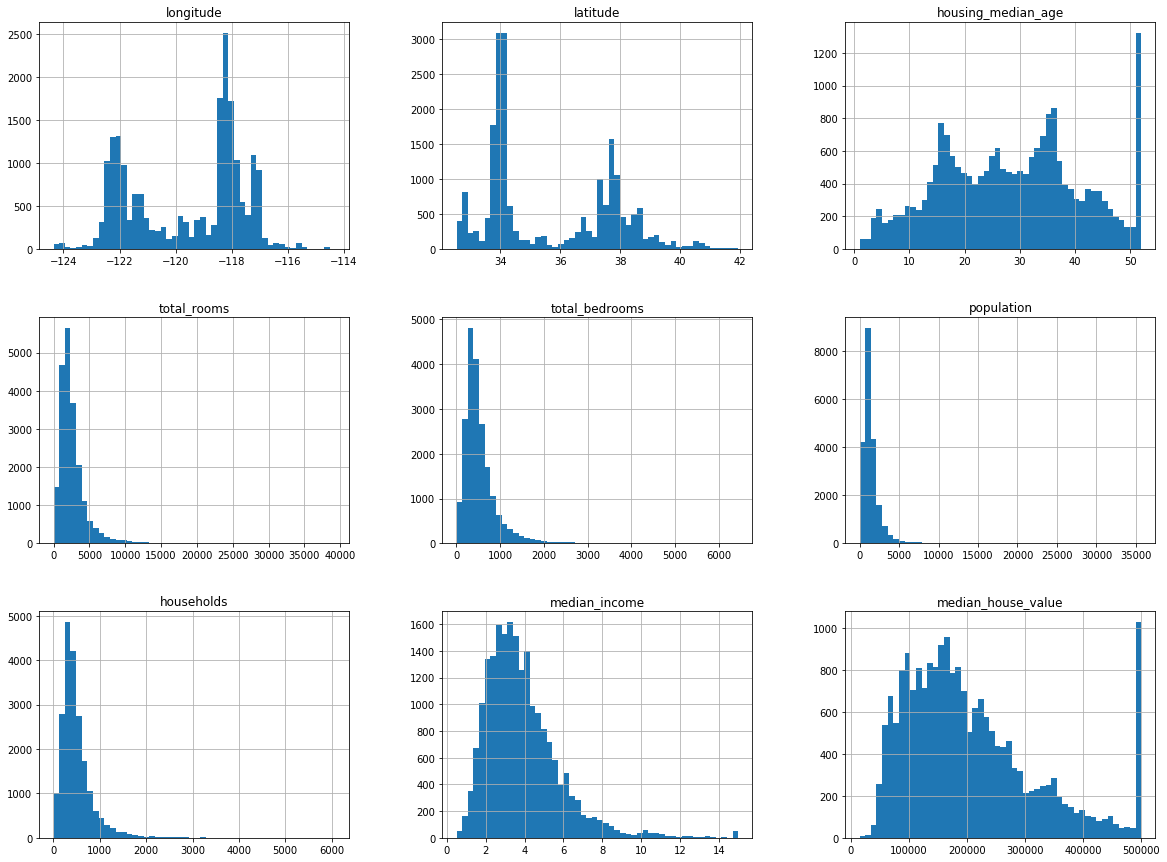

In [8]:

def numerical_hist(df, bins, fig1,fig2):
    df.hist(bins=bins, figsize=(fig1,fig2))
    plt.show()

numerical_hist(housing, 50, 20,15)

## Analysis of histograms
- Most see to be right tail heavy 
- The median house value seems to be capped at 500,000
- The median income is not represented in currency, it seems to be scaled so 4 = 40000
- Most features have a somewhat normal distribution while long,lat and age dont resemble a normal distribution at all 

In [9]:
from sklearn.model_selection import train_test_split
features = housing.drop(columns='median_house_value')
targets = pd.DataFrame(housing['median_house_value'])
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = 0.3, random_state = 42)


The reason to perform the train/test split this early is we are working with one dataframe, alot of the time there is seperate test and train csv files, however in this case since we have on dataset we need to split before feature engineering as there can be information leakage, if done before, from the Test-Set.

A good explaination for why to split before featurization can be found here: <br> https://stats.stackexchange.com/questions/338400/featurization-before-or-after-dataset-splitting

"Let's consider one of the most common data-transformation procedures, centring. We get an "expected value" μ^xj for our feature xj and then we subtract that from the values of xj, nothing magical. A central question is: what this "expected value" reflects; does it reflect our understanding of xj using the whole sample or just the training sample? If we use the whole sample we have what is called data-leakage, "we cheat" using information that should be available during prediction. To give an NLP example, if some very unusual word or n-gram is present in our corpus and all instances happen to land in the test set, it is obviously wrong to inform the process of convert our collection of text documents to a matrix of token counts with that unusual n-gram. It will give us a false scene of security about the generalised performance of our procedure. Therefore, when doing serious feature extraction/engineering we need to use only the training data and not the whole dataset."

# Exploratory Data Analysis

C:\Users\johnl\Anaconda\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\johnl\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\johnl\Anaconda\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\johnl\Anaconda\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support fo

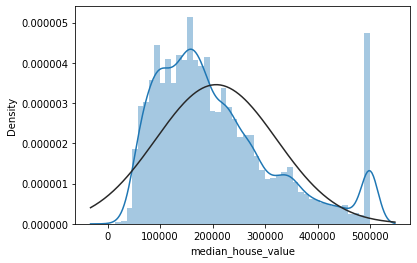

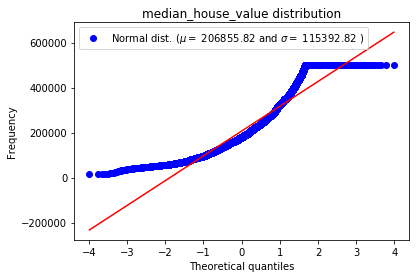

In [10]:

from scipy import stats
def continous_target_visualiztion(df,target):
    (mu, sigma) =stats.norm.fit(df[target])
    sns.distplot(df[target], fit = stats.norm)
    fig = plt.figure()
    res = stats.probplot(df[target], plot=plt)

    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title(str(target)+ " distribution")
              
continous_target_visualiztion(housing,"median_house_value")

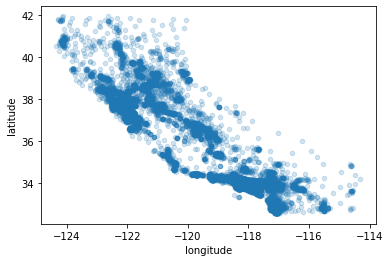

In [11]:
housing.plot(kind="scatter", x="longitude", y="latitude",alpha = 0.2)

In [12]:
# minimum and maximum longitude test set
min_long =(housing.longitude.min())
max_long = (housing.longitude.max())
# minimum and maximum latitude test
min_lat = (housing.latitude.min())
max_lat = (housing.latitude.max())
boundary_shape = (min_long,max_long,min_lat, max_lat)

In [13]:
print(min_long,max_long,min_lat, max_lat)

-124.35 -114.31 32.54 41.95


In [14]:
def boundary(df, boundary_shape):
    return (df.longitude >= boundary_shape[0]) & (df.longitude <= boundary_shape[1]) & \
           (df.latitude >= boundary_shape[2]) & (df.latitude <= boundary_shape[3]) & \
           (df.longitude >= boundary_shape[0]) & (df.longitude <= boundary_shape[1]) & \
           (df.latitude >= boundary_shape[2]) & (df.latitude <= boundary_shape[3])
boundary_shape = (min_long,max_long,min_lat, max_lat)
boundary_long = (min_long,max_long)
boundary_lat =  (min_lat, max_lat)
cali_map = plt.imread(r"C:\Users\johnl\Documents\California Housing\California_map.jpg")
 

In [15]:

boundary_shape = (-125,-114,32.4,42)

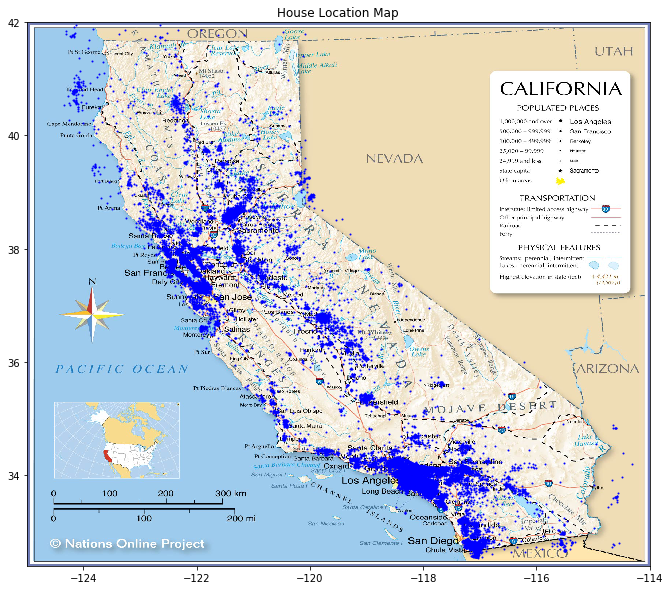

In [16]:

def plot_on_map(df, boundary_shape, cali_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 1, figsize=(16,10))
    # this line will generate our scatter plot on a normal plot
    axs.scatter(df.longitude, df.latitude, zorder=1, alpha=alpha, c='blue', s=s)
    # sets limits
    axs.set_xlim((boundary_shape[0], boundary_shape[1]))
    axs.set_ylim((boundary_shape[2], boundary_shape[3]))
    axs.set_title('House Location Map')
    #imshow overlays our image on the graph
    #The Zorder attribute of the Matplotlib Module helps us to improve the overall representation of our plot
    #This property determines how close the points or plot is to the observer. 
    #The higher the value of Zorder closer the plot or points to the viewer.
    # Extent defines the left and right limits, and the bottom and top limits.
    # It takes four values like so: extent=[horizontal_min,horizontal_max,vertical_min,vertical_max].
    axs.imshow(cali_map, zorder=0, extent=boundary_shape)

plot_on_map(housing, boundary_shape, cali_map, s=1, alpha=1)

From our graph overlay the data seems to line up fairly consistently, with the biggest clusters matching the biggest cities in California

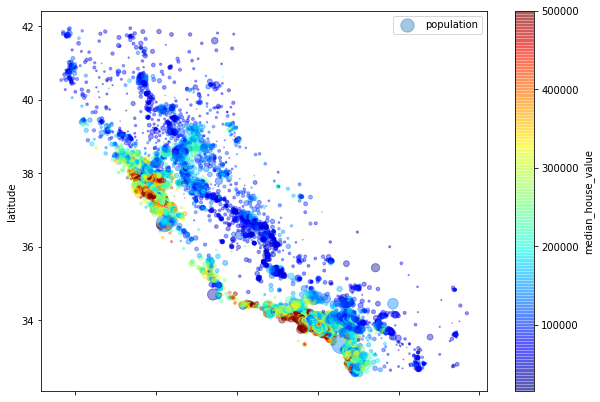

In [17]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
 s=housing["population"]/100, label="population", figsize=(10,7),
 c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()


This follows conventional standards of the coast, the closer you are the more expensive the property, As you move inwards from the coast the price drops 

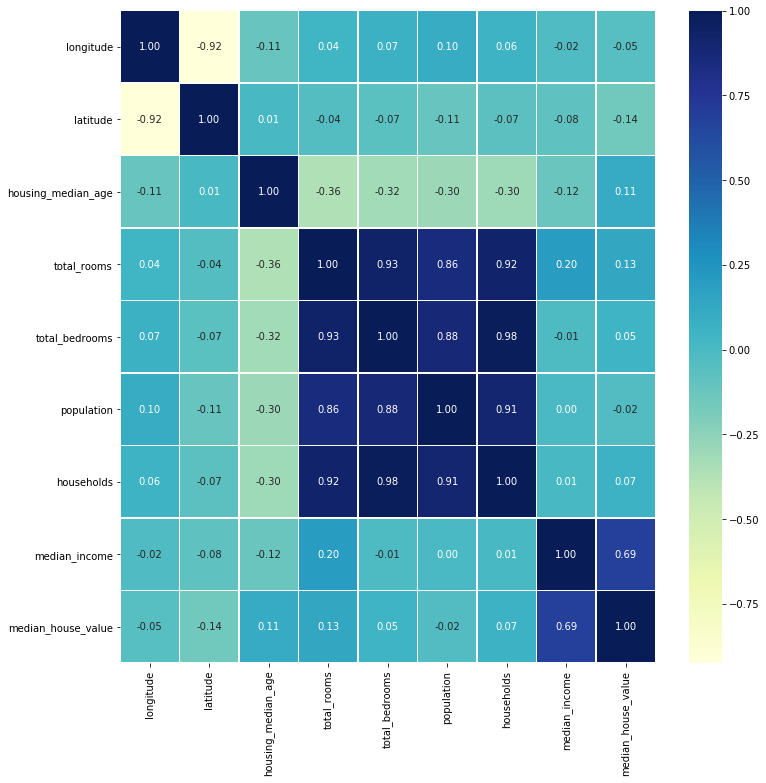

In [18]:
def corr_mat(df,annot = False):
    corrmat = df.corr()
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.heatmap(corrmat,
                     annot=annot,
                     linewidths=0.5,
                     fmt=".2f",
                     cmap="YlGnBu");
    bottom, top = ax.get_ylim()
corr_mat(housing, True)

We drk blue square in the center of our matrix suggests we have a clear problem with multicollinearity that needs to be addressed, the best predictor of median house value is median income, the other varaibles dont seem to have much correlation. Since features such as total rooms and total bedrooms have a near perfect correlation but provide very low correlation to our target variable we might consider dropping them from the data, we can also use them to produce more effective and beneifical features such as rooms per house rather than total rooms

C:\Users\johnl\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\johnl\Anaconda\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\johnl\Anaconda\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0.5, 1.0, 'Median house value vs Median income')

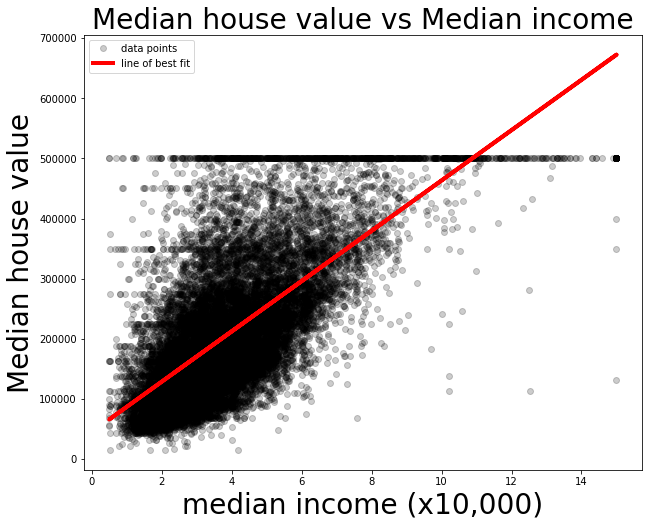

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))
df= housing.copy()
df.dropna(inplace=True)
y = df['median_house_value']
x =  df['median_income']
plt.plot(x, y,"o", color = "black",alpha = 0.2)
m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, linewidth = 4, color = "red")

size = 28
plt.legend(["data points", "line of best fit"])
plt.xlabel("median income (x10,000)", size = size)
plt.ylabel('Median house value',size = size)
plt.title('Median house value vs Median income', size = size)

We definitly need to address the price cap, it will make predicting house prices above the cutoff difficult , we also have outliers trending towards higher income with low value property, however there is a clear strong positive linear relationship between median income and median house value. There also seems to be horizontal bands through the data, these will need to be removed 

# to do 
impute missing values, address mutlicollinearity, make new features

## Feature Engineering

In [20]:
housing["rooms_per_house"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_house"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

## Missing Values

In [21]:

from sklearn.impute import SimpleImputer


def imputer_function(df, strategy):
    imputer = SimpleImputer(strategy=strategy)
    X_numeric = df.select_dtypes(['number']) 
    imputer.fit(X_numeric)
    X_trans = imputer.transform(X_numeric)
    X = pd.DataFrame(X_trans, columns=X_numeric.columns)
    return X

housing_num = imputer_function(housing, "median")


In [22]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat = housing[["ocean_proximity"]]

housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

C:\Users\johnl\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:395: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  check_array(X, dtype=np.int)
C:\Users\johnl\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use,

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
num_pipeline = Pipeline([
 ('imputer', SimpleImputer(strategy="median")),
 ('std_scaler', StandardScaler()),
 ])
housing_num_transformed = num_pipeline.fit_transform(housing_num)


In [24]:
from sklearn.compose import ColumnTransformer
num_attribs =list(housing.select_dtypes(include=[np.number]).columns.values)
num_attribs.remove("median_house_value")
cat_attribs = ["ocean_proximity"]
full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(), cat_attribs),
 ])
housing_prepared = full_pipeline.fit_transform(housing)

C:\Users\johnl\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:395: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  check_array(X, dtype=np.int)
C:\Users\johnl\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use,

# Model

In [25]:
from sklearn.model_selection import train_test_split
X = housing.drop('median_house_value',axis=1)
y = housing.median_house_value

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [28]:

X_train= full_pipeline.transform(X_train)
X_test= full_pipeline.transform(X_test)
# Function to calculate mean absolute error
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions and evalute
    model_pred = model.predict(X_test)
    model_mae = rmse(y_test, model_pred)
    
    # Return the performance metric
    return model_mae

results_df = pd.DataFrame(columns=['Model', 'Accuracy'])

C:\Users\johnl\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:110: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_int = np.zeros((n_samples, n_features), dtype=np.int)
C:\Users\johnl\Anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:111: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more deta

In [29]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
score = fit_and_evaluate(lin_reg)
results_df_lin = pd.DataFrame(data=[["Linear Regression", score]], 
                          columns=['Model', 'Accuracy'])
results_df = results_df.append(results_df_lin, ignore_index=True)

In [30]:
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

C:\Users\johnl\Anaconda\lib\site-packages\dask\dataframe\utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [31]:
from lightgbm import LGBMRegressor

lgbm_reg =LGBMRegressor()
score = fit_and_evaluate(lgbm_reg)
results_df_lgbm = pd.DataFrame(data=[["LGBM Regression", score]], 
                          columns=['Model', 'Accuracy'])
results_df = results_df.append(results_df_lgbm, ignore_index=True)

In [32]:
from xgboost import XGBRegressor
xgb_reg =XGBRegressor()
score = fit_and_evaluate(xgb_reg)
results_df_xgb= pd.DataFrame(data=[["XGB Regression", score]], 
                          columns=['Model', 'Accuracy'])
results_df = results_df.append(results_df_xgb, ignore_index=True)

In [33]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rf_reg =RandomForestRegressor()
score = fit_and_evaluate(rf_reg)
results_df_rf= pd.DataFrame(data=[["Random Forest Regression", score]], 
                          columns=['Model', 'Accuracy'])
results_df = results_df.append(results_df_rf, ignore_index=True)

C:\Users\johnl\Anaconda\lib\site-packages\sklearn\decomposition\online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
C:\Users\johnl\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import predict_stages
C:\Users\jo

In [34]:
gbr_reg = GradientBoostingRegressor()
score = fit_and_evaluate(gbr_reg)
results_df_gbr= pd.DataFrame(data=[["Gradient Boosted Regression", score]], 
                          columns=['Model', 'Accuracy'])
results_df = results_df.append(results_df_gbr, ignore_index=True)

C:\Users\johnl\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1348: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.object)
C:\Users\johnl\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1570: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_mask = np.ones((n_samples, ), dtype=np.bool)
C:\Users\johnl\Anaconda\lib\site-packages\sklearn\ensemble\gradient_boosting.py:1

In [35]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor()
score = fit_and_evaluate(knn_reg)
results_df_knn= pd.DataFrame(data=[["KNeighbors Regression", score]], 
                          columns=['Model', 'Accuracy'])
results_df = results_df.append(results_df_knn, ignore_index=True)

In [38]:
results_df.sort_values(by='Accuracy')

,Model,Accuracy
1,LGBM Regression,45834.479084
2,XGB Regression,46151.118526
3,Random Forest Regression,51712.901395
4,Gradient Boosted Regression,53173.072929
5,KNeighbors Regression,61624.960815
0,Linear Regression,67976.340869


In [45]:
lgbm_reg.fit(X_train,y_train)
model_pred = lgbm_reg.predict(X_train)
model_mae = rmse(y_train, model_pred)
print(model_mae)

38932.44299497781


best models are lgbm and xgb, (still need to fine tune)